## Reproducing results

This notebook can be used to parse and visualize the results from _Accurate peptide fragmentation predictions allow data driven approaches to replace and improve upon proteomics search engine scoring functions_. The files loaded in this notebook correspond to the _Pyrococcus furiosus_ dataset, available on this repository, but feel free to adapt them to other files. To reproduce results described in the manuscript, links to download some necessary files can be found in the [wiki](https://github.com/anasilviacs/rescore/wiki/Reproducing-manuscript-results)). As such, if you generated the `pin` file and you executed Percolator as:

`percolator Velos005137.pin -m Velos005137.pout -M Velos005137.pout_decoys -w Velos005137.weights -U`

you should have the following files:

- <file\>.pin
- <file\>.pout
- <file\>.pout_dec
- <file\>.weights

The code is meant to be run in `python 3`. If using a previous version, some changes maybe necessary. First, some python packages must be imported and a function to calculate each PSM's q-value is defined:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

def calc_qval(df_in, decoy_col='Decoy', score_col='Score', better_score='higher', correct_pi_zero=True):
    """
    Read a dataframe with at the very keast, for each PSM, a column indicating if it is a decoy and 
    another column with the score, and returns a q-value for each PSM
    
    :param df_in: dataframe
    :param decoy_col: name of the boolean column where 1 = decoy
    :param score_col: name of the column with the scores
    :param better_score: 'higher' if higher scores are better, 'lower' otherwise
    :param correct_pi_zero: correct for imbalance in distributions
    
    Returns
    :pd.Series 'q_val' qith the q-value for each PSM
    """
    
    if better_score == 'higher':
        sort_ascending = False
    elif better_score == 'lower':
        sort_ascending = True

    df = df_in.sort_values(score_col, ascending=sort_ascending)

    if correct_pi_zero:
        pi_zero_correction = df[decoy_col].value_counts()[False] / df[decoy_col].value_counts()[True]
    else:
        pi_zero_correction = 1
    df['decoy_cumsum'] = df[decoy_col].cumsum()
    df['target_cumsum'] = (~df[decoy_col]).cumsum()
    df['q_val'] = (df['decoy_cumsum'] / df['target_cumsum']) * pi_zero_correction

    return df['q_val'].sort_index()

### Reading in the data

Read the `pin` file:

In [2]:
pin = pd.read_csv('pyrfu/Velos005137.pin', index_col=0, sep='\t')
pin.head()

,Label,ScanNr,spec_pearson_norm,ionb_pearson_norm,iony_pearson_norm,spec_mse_norm,ionb_mse_norm,iony_mse_norm,min_abs_diff_norm,max_abs_diff_norm,...,iony_mean_abs_diff,iony_std_abs_diff,dotprod,dotprod_ionb,dotprod_iony,cos,cos_ionb,cos_iony,Peptide,Proteins
SpecId,,,,,,,,,,,,,,,,,,,,,
667.3291015625_301.37059999998,1,0,0.782326,0.856641,0.877926,1.553498,2.365232,0.741765,2.846621e-07,2.137053,...,0.006438,0.007962,0.004483,5.325955e-04,0.003950,0.832314,0.961871,0.944230,X.SGPHKGEHLDEK.X,tr|Q8U1K3|Q8U1K3_PYRFU
552.78076171875_333.82939999998,1,1,0.633693,0.161431,0.754826,5.567076,5.052485,6.081668,2.846621e-07,4.671616,...,0.016276,0.015894,0.003029,6.574194e-05,0.002963,0.927671,0.476190,0.947642,X.EWDMRVIR.X,sp|Q8U0F2|Y1638_PYRFU
439.266662597656_355.96849999998,-1,2,0.062635,0.000000,-0.339121,15.615001,5.673053,25.556950,2.846621e-07,7.477644,...,0.054223,0.056502,0.000378,8.540082e-12,0.000378,0.060028,0.520192,0.060718,X.IIGLVMSK.X,XXX_tr|Q8U2L1|Q8U2L1_PYRFU
436.758575439453_357.4905,1,3,0.929323,0.984247,0.829668,0.660872,0.222836,1.098907,2.846621e-07,2.091799,...,0.012648,0.015373,0.036128,1.062338e-02,0.025505,0.975587,0.998723,0.982562,X.VHPAHALK.X,tr|Q8U2K9|Q8U2K9_PYRFU
325.526702880859_368.52880000002,-1,4,0.506194,0.000000,0.342834,8.361746,0.470659,16.252834,2.846621e-07,6.738872,...,0.030139,0.033426,0.000133,6.216923e-13,0.000133,0.414726,0.539873,0.414796,X.EIESLVKR.X,XXX_sp|Q8TZY2|SMC_PYRFU


Following this, read in the `pout` and `pout_decoys` files, and concatenate them into a single dataframe:

In [3]:
pout = pd.read_csv('pyrfu/Velos005137.pout', index_col=0, sep='\t')
pout['decoy'] = [False] * len(pout)

pout_dec = pd.read_csv('pyrfu/Velos005137.pout_decoys', index_col=0, sep='\t')
pout_dec['decoy'] = [True] * len(pout_dec)

pout = pd.concat([pout, pout_dec])

pout.head()

,score,q-value,posterior_error_prob,peptide,proteinIds,decoy
PSMId,,,,,,
357.219268798828_2185.5429,7.25594,0.000247,1.841110e-16,X.RLDLVNALR.X,tr|O51923|O51923_PYRFU,False
501.322204589844_359.6895,6.56435,0.000247,5.720970e-15,X.KKIDELKK.X,sp|Q8U0J4|RF1_PYRFU,False
528.326721191406_564.93190000002,5.87184,0.000247,1.785750e-13,X.KVEPVKVEK.X,tr|Q8U304|Q8U304_PYRFU,False
903.482543945313_3134.40760000002,5.74704,0.000247,3.319890e-13,X.VLAVPVEDPYFKDWK.X,sp|Q8U438|IPYR_PYRFU,False
686.361694335938_2816.6151,5.48677,0.000247,1.209940e-12,X.DEAIEGQIANAIK.X,tr|Q8U136|Q8U136_PYRFU,False


The `pin` and `pout` dataframes can be merged:

In [4]:
df = pd.merge(pin, pout, left_index=True, right_index=True)
df.head()

,Label,ScanNr,spec_pearson_norm,ionb_pearson_norm,iony_pearson_norm,spec_mse_norm,ionb_mse_norm,iony_mse_norm,min_abs_diff_norm,max_abs_diff_norm,...,cos_ionb,cos_iony,Peptide,Proteins,score,q-value,posterior_error_prob,peptide,proteinIds,decoy
667.3291015625_301.37059999998,1,0,0.782326,0.856641,0.877926,1.553498,2.365232,0.741765,2.846621e-07,2.137053,...,0.961871,0.944230,X.SGPHKGEHLDEK.X,tr|Q8U1K3|Q8U1K3_PYRFU,1.706330,0.000314,0.000174,X.SGPHKGEHLDEK.X,tr|Q8U1K3|Q8U1K3_PYRFU,False
552.78076171875_333.82939999998,1,1,0.633693,0.161431,0.754826,5.567076,5.052485,6.081668,2.846621e-07,4.671616,...,0.476190,0.947642,X.EWDMRVIR.X,sp|Q8U0F2|Y1638_PYRFU,-0.714947,0.038665,0.868186,X.EWDMRVIR.X,sp|Q8U0F2|Y1638_PYRFU,False
439.266662597656_355.96849999998,-1,2,0.062635,0.000000,-0.339121,15.615001,5.673053,25.556950,2.846621e-07,7.477644,...,0.520192,0.060718,X.IIGLVMSK.X,XXX_tr|Q8U2L1|Q8U2L1_PYRFU,-2.357850,0.090581,0.956401,X.IIGLVMSK.X,XXX_tr|Q8U2L1|Q8U2L1_PYRFU,True
436.758575439453_357.4905,1,3,0.929323,0.984247,0.829668,0.660872,0.222836,1.098907,2.846621e-07,2.091799,...,0.998723,0.982562,X.VHPAHALK.X,tr|Q8U2K9|Q8U2K9_PYRFU,1.890590,0.000314,0.000070,X.VHPAHALK.X,tr|Q8U2K9|Q8U2K9_PYRFU,False
325.526702880859_368.52880000002,-1,4,0.506194,0.000000,0.342834,8.361746,0.470659,16.252834,2.846621e-07,6.738872,...,0.539873,0.414796,X.EIESLVKR.X,XXX_sp|Q8TZY2|SMC_PYRFU,-1.272560,0.062855,0.943336,X.EIESLVKR.X,XXX_sp|Q8TZY2|SMC_PYRFU,True


#### Note
Since in the current files there isn't any information pertaining the original search, the plots below reflect only the performance of the new score in separating target and decoy PSMs.

The distribution of Percolator scores for the target and decoy distributions can be visualized in a histogram of scores, split by the `decoy` column in the dataframe.

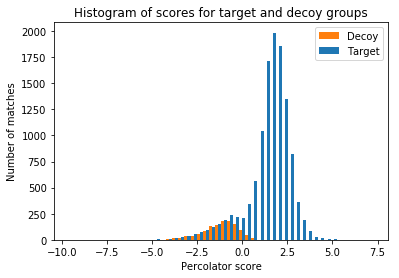

In [5]:
# Score distribution

plot_list = [list(x) for x in [df[df['decoy']]['score'], df[~df['decoy']]['score']]]
plt.hist(plot_list, bins=50, label=['Decoy', 'Target'], color=[sns.color_palette()[1], sns.color_palette()[0]], lw=1, rwidth=1)

plt.ylabel("Number of matches")
plt.xlabel('Percolator score')
plt.legend()
plt.title('Histogram of scores for target and decoy groups')

plt.show()

The q-values are calculated for each PSM based on the distribution of target and decoy scores. A line plot shows how this value changes with the score.

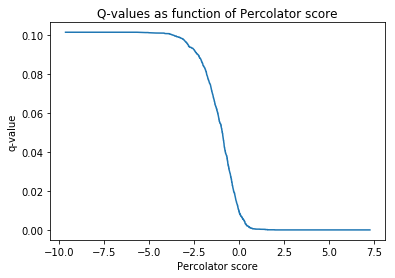

In [6]:
plt.plot(df.sort_values('score')['score'], df.sort_values('score')['q-value'])

plt.ylabel('q-value')
plt.xlabel('Percolator score')

plt.title('Q-values as function of Percolator score')

plt.show()

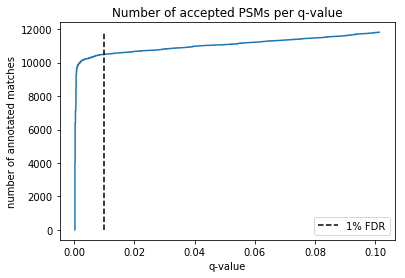

In [7]:
df = df.sort_values('q-value', ascending=True)
df['count'] = (~df['decoy']).cumsum()

plt.plot(df['q-value'], df['count'], label='_nolegend_')
plt.plot([0.01]*2, np.linspace(0,np.max(df['count']),2), linestyle='--', color='black', label='1% FDR')


plt.xlabel('q-value')
plt.ylabel('number of annotated matches')
plt.legend()

plt.title('Number of accepted PSMs per q-value')

plt.show()

Another important consideration is an evaluation of how well the decoy scores represent the false positive's scores; this can be done using a PP plot for the target vs the decoy scores.

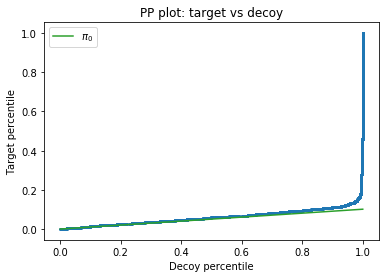

In [8]:
ratio = df['decoy'].value_counts()[True] / df['decoy'].value_counts()[False]
Ft = ECDF(df[~df['decoy']]['score'])
Fd = ECDF(df[df['decoy']]['score'])
x = df[~df['decoy']]['score']
Fdp = Fd(x)
Ftp = Ft(x)

plt.scatter(Fdp, Ftp, s=4)
plt.plot((0,1), (0, ratio), color=sns.color_palette()[2], label=r'$\pi_0$')

plt.legend()
plt.xlabel('Decoy percentile')
plt.ylabel('Target percentile')

plt.title('PP plot: target vs decoy')
plt.show()

### Visualizing feature weights

If you are interested in better understanding the scoring function that Percolator defines, you can inspect the weights file.

In [9]:
w = pd.read_csv('pyrfu/Velos005137.weights', sep='\t')
plt.figure(figsize=(5,23))
w = w.drop([1,2,4,5,7])
w = w.astype(float)
w.head()

,spec_pearson_norm,ionb_pearson_norm,iony_pearson_norm,spec_mse_norm,ionb_mse_norm,iony_mse_norm,min_abs_diff_norm,max_abs_diff_norm,abs_diff_Q1_norm,abs_diff_Q2_norm,...,iony_abs_diff_Q3,iony_mean_abs_diff,iony_std_abs_diff,dotprod,dotprod_ionb,dotprod_iony,cos,cos_ionb,cos_iony,m0
0,-0.0766,1.2021,0.1364,-0.7041,-0.4147,-0.7375,-0.0364,-0.0315,0.3022,0.9216,...,0.0020,-0.0879,-1.1505,0.0958,0.7852,-0.1995,0.9168,0.3740,0.1575,2.0825
3,0.4220,0.4019,-0.3936,-0.5452,-0.8257,-0.3779,-0.2147,0.1224,0.1159,-0.0189,...,-0.1079,-0.6808,-0.1032,0.0548,0.6947,-0.2110,0.4347,0.3050,0.5626,2.0085
6,1.0680,1.0075,0.0893,-1.7008,-0.2440,-2.0715,-0.1515,0.0509,0.0756,0.6854,...,0.0302,-0.6286,-1.3487,0.2648,0.9134,-0.0557,0.8798,0.2495,0.4616,1.9995


<Figure size 360x1656 with 0 Axes>

Some rows were dropped because they refer either to the headers or to a normalized weight. We are now looking at the raw weights that Percolator uses to calculate the new score. Percolator uses a nested `k`-fold cross-validation scheme, so it in fact divides the whole set of PSMs into `k` and uses a different scoring function for each (although they are posteriorly normalized so that the entire dataset can be processed together). The weights can be utilized to verify how these scoring functions differently weigh each feature:

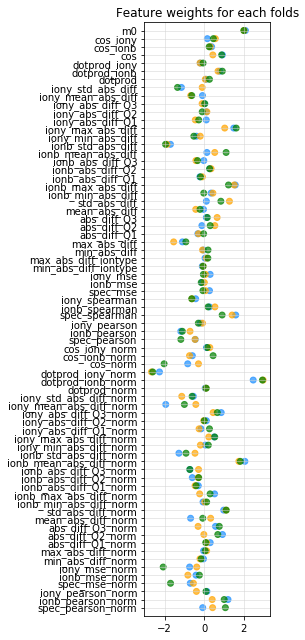

In [10]:
f, ax = plt.subplots(1,1, figsize=(4,9))

for i, f in enumerate(w.columns):
    ax.scatter(w.loc[:,f], [i]*len(w.iloc[:,i]), c=['dodgerblue', 'orange', 'green'], alpha=0.7)
    
ax.set_ylim([-1, len(w.columns)])
ax.set_yticks(list(range(len(w.columns))))
ax.set_yticklabels(w.columns)
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.title('Feature weights for each folds')
plt.tight_layout()
plt.show()